# Graph dataset generation

This file contains code to generate and store a dataset of latents that represent objects during Phyre runs. It can be used to load trajectories at training time which encode states $s_{t}, s_{t+1}, ... by latent object properties. A run loaded from the dataset has shape `(T, n_frame_objs, n_obj_properties)`, where `T` is the trajectory length, `n_frame_objs` is the number of object per frame (assumed to be constant in a given run) and `n_obj_properties` contains the different object features.

The object features contain x, y, and some other parameters which are extracted directly from the Phyre simulations, i.e. they are ground truths. If you want to change the information present in nodes or edge attributes, edit `extract_objects()`, or `create_sequence_graphs()` respectively.

You can adjust configuration parameters such as which Phyre templates and tasks are used, or which compression is used, in the cells in section __Config__. In contrast to images, a latents dataset should not really benefit from compression since it is already pretty dense information.

In [16]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import phyre
from tqdm import tqdm
import h5py
from phyre import SimulationStatus
from itertools import combinations

### Config

In [17]:
DIR = "./data"
# used to name the hdf5 file
DATASET_NAME = "phyre_diff_00_1_tasks_1_action_latents"
hdf5_filename = f"{DIR}/{DATASET_NAME}.h5"
compression = None # "lzf"

Path(DIR).mkdir(exist_ok=True, parents=True)

# hdf attribute keys
ATTRIBUTE_SUCCESS_KEY = "ATTRIBUTE_SUCCESS"
CLOSE_FAIL_KEY = "ATTRIBUTE_CLOSE_FAIL"
ACTION_KEY = "ATTRIBUTE_ACTION"

In [18]:
# tier
tier = 'ball'  # use 'two_balls' for templates with two placeable balls

template_ids = ['00000']

task_ids = None  #{0: ["087", "854"]} #  template_idx to [task_idx], if None choose random tasks

# how many tasks to choose per template, only applies if task_ids is None
num_tasks_per_template = 1

# number of positive actions to simulate for each task, template pair
num_pos_actions = 1
# number of "close" negative actions to generate for each positive action
num_close_neg_actions = 0
# number of negative actions to simulate for each task, template pair
num_neg_actions = 0

# Stride means we take only every Xth point in the trajectory
stride = 3

### Initialization

In [19]:
# cache consists of pre-computed simulations for a given task and action
cache = phyre.get_default_100k_cache(tier)

In [20]:
# get all tasks which should be considered
template_task_ids = []
if task_ids is not None:
    for idx, template_id in enumerate(template_ids):
        template_task_ids += [(template_id, task_id) for task_id in task_ids[idx]]
else:
    for template_id in template_ids:
        all_tasks = [(template_id, task.split(":")[1]) for task in cache.task_ids if task.startswith(template_id)]
        template_task_ids += random.sample(all_tasks, num_tasks_per_template)

In [21]:
# initialize simulator and cache
all_ids = [f"{template_id}:{task_id}" for template_id, task_id in template_task_ids]
simulator = phyre.initialize_simulator(all_ids, tier)
sample = cache.get_sample(all_ids)

### Preprocessing of features

In [22]:
def extract_objects(featurized_objects: phyre.FeaturizedObjects):
    """
    Takes a FeaturizedObjects instance (representing one trajectory/simulation) and extracts object information
    xs, ys, cos_angles, sin_angles, diameters, colors, shapes
    and returns them as an np.ndarray of shape (T, n_frame_objs, n_obj_properties),
    where frame objects is the number of objects per frame.
    """
    # Documentation for what's in featurized_objects: https://phyre.ai/docs/simulator.html#phyre.FeaturizedObjects
    xs = featurized_objects.states[:,:,0]
    ys = featurized_objects.states[:,:,1]
    angles = featurized_objects.states[:,:,2]
    cos_angles = np.cos(angles*np.pi*2)
    sin_angles = np.sin(angles*np.pi*2)
    T = len(xs)
    diameters = np.tile(featurized_objects.diameters, (T, 1)) # Expand diameters of shape (num_objects,) to match xs and ys dimensions
    colors = np.tile(featurized_objects.colors_one_hot,(T,1,1)) # Expand to length T
    shapes = np.tile(featurized_objects.shapes_one_hot,(T,1,1)) # Expand to length T

    objects = np.concatenate((
            xs[:,:,None],
            ys[:,:,None],
            sin_angles[:,:,None],
            cos_angles[:,:,None],
            diameters[:,:,None],
            shapes, # one hot encoded
            colors), # one hot encoded
        axis=-1)

    return objects

### Storage

In [23]:
def create_hdf5_file():
    return h5py.File(hdf5_filename, "w")

In [24]:
def open_hdf5_file():
    return h5py.File(hdf5_filename, "r")

In [25]:
def save_simulation_to_hdf5_file(file: h5py.File, objects, template, task, run_number, simulation_status,
                                 close_fail=False, action=None, compression=None):
    # This saves the latents of one run to the dataset
    
    dataset = file.create_dataset(f"{template}/{task}/{run_number}",
                                 data = objects,
                                 chunks=True,
                                 compression=compression)

    dataset.attrs[ATTRIBUTE_SUCCESS_KEY] = simulation_status == SimulationStatus.SOLVED
    dataset.attrs[CLOSE_FAIL_KEY] = close_fail
    dataset.attrs[ACTION_KEY] = action

### Distance Metrics

In [26]:
def action_distance(a, b):
    return np.linalg.norm(a - b)

### Dataset Generation

In [27]:
file = create_hdf5_file()
sample_images = np.zeros((len(all_ids), 256, 256))
for task_idx, task in enumerate(all_ids):
    print(f"Task: {task}")
    template_id, task_id = task.split(":")
    success_idxs = []
    fail_idxs = []

    for i, simulation_status in enumerate(sample["simulation_statuses"][task_idx]):
        if simulation_status == SimulationStatus.SOLVED:
            success_idxs.append(i)
        elif simulation_status == SimulationStatus.NOT_SOLVED:
            fail_idxs.append(i)

    successes = random.sample(success_idxs, num_pos_actions)

    close_fails = []
    for success in tqdm(successes, desc="Finding close fails"):
        positive_action = sample["actions"][success]
        fails_sorted_by_dist = sorted(fail_idxs.copy(),
                                      key=lambda x: action_distance(positive_action, sample["actions"][x]))
        close_fails.extend(fails_sorted_by_dist[:num_close_neg_actions])
        
    fails = random.sample(fail_idxs, num_neg_actions)
    
    # Create a sample image for each task
    sample_image = simulator.simulate_action(task_index=task_idx, action=sample["actions"][successes[0]],
                                             need_images=True, need_featurized_objects=False, stride=1000).images[0]
    sample_images[task_idx] = sample_image

    for run_number, action_idx in enumerate(tqdm((successes + fails + close_fails), desc="Saving action simulations", unit="actions")):
        action = sample["actions"][action_idx]

        simulation = simulator.simulate_action(task_index=task_idx, action=action, need_images=False, stride=stride,
                                               need_featurized_objects=True)

        objects = extract_objects(simulation.featurized_objects)
        
        save_simulation_to_hdf5_file(file, objects, template_id, task_id, run_number, simulation.status,
                                     action=action, close_fail=action_idx in close_fails, compression=compression)


file.close()

Task: 00000:096


Saving action simulations: 100%|██████████| 1/1 [00:00<00:00, 88.48actions/s]


### Experimentation / Loading

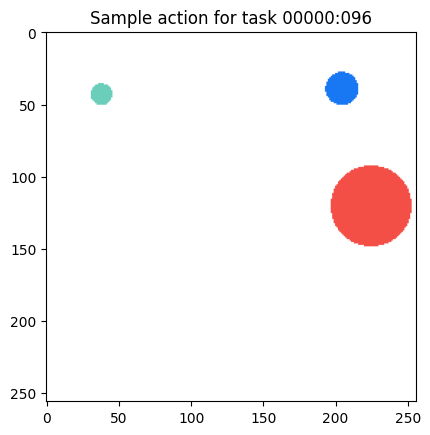

In [28]:
# Show a sample image for each of the stored tasks
for task_idx, task in enumerate(all_ids):
    plt.figure()
    plt.imshow(phyre.observations_to_uint8_rgb(sample_images[task_idx].astype(np.int8)))
    plt.title(f"Sample action for task {task}")
    plt.show()
    plt.close()

In [29]:
# Print lengths of trajectories
with open_hdf5_file() as f:
    for template_id in f.keys():
        print(template_id)
        for task_id in f[template_id].keys():
            print(task_id)
            for run in f[template_id][task_id]:
                print(f[template_id][task_id][run].shape)

00000
096
(207, 3, 15)


In [30]:
open_hdf5_file().filename

'./data/phyre_diff_00_1_tasks_1_action_latents.h5'